In [1]:
import os
def get_hostname():
    with open("/etc/hostname") as f:
        hostname=f.read()
    hostname=hostname.split('\n')[0]
    return hostname
class Globals():
    def __init__(self):
        self.default_data='celeba'
        hostname=get_hostname()
        self.default_root_dir= '/home/yang/data/' if hostname=="Dragon" else '../data/' if hostname.count("nikola") else '/prem/'
        self.default_feature_dir= '/home/yang/data/features/' if hostname=="Dragon" else '/home/gh349/gan/data/features/' if hostname.count("nikola") else '/shared/features/'
        self.default_repo_dir= self.default_root_dir + 'repo/'
        self.default_data_dir= '/scratch/gh349/' if hostname.count("nikola") else self.default_root_dir + 'data/'
        self.default_model_dir= '/home/gh349/gan/data/models/' if hostname.count("nikola") else self.default_root_dir + 'models/'
        self.default_ground_truth_folder='true'
def mkdir(fname):
    try:
        os.makedirs(fname)
    except OSError:
        pass

In [49]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from matplotlib.ticker import FormatStrFormatter

g=Globals()

def cut(name):
    if 'inception_v3' in name or 'resnet34_random' in name:
        name=name[name.index("_")+1:]
        name=name[name.index("_")+1:]
    elif 'resnet34' in name or 'vgg' in name:
        name=name[name.index("_")+1:]
    name=name[name.index("_")+1:]
    return name[name.index("_")+1:]
def getMeanStd(objL,attr):
    l=[]
    for obj in objL:
        if attr.startswith('knn'):
            l.append(getattr(obj.knn,attr[3:]))
        else:
            l.append(getattr(obj,attr))
    return np.mean(l),np.std(l)

#def get_y(fileName,inList):
#    rlt_dir=g.default_repo_dir+"rlt/" #
#    rlt={}
#    metricList=inList[:]
#    if 'incep' in metricList:
#        objL=[]
#        for i in range(0,5):
#            #print(np.load(rlt_dir+"incep_"+cut(fileName)+"_"+str(i)))
#            objL.append(np.load(rlt_dir+"incep_"+cut(fileName)+"_"+str(i)))  # random_incep_celeba/    
#        rlt['incep'],rlt['incep_std']=np.mean(objL),np.std(objL)
#        metricList.remove('incep')
#    if 'mode_score' in metricList:
#        objL=[]
#        for i in range(0,5):
#            #print(rlt_dir+"mode_score_"+cut(fileName)+"_"+str(i))
#            objL.append(np.load(rlt_dir+"mode_score_"+cut(fileName)+"_"+str(i))) #random_mode_score_celeba/      
#        rlt['mode_score'],rlt['mode_score_std']=np.mean(objL),np.std(objL)
#        metricList.remove('mode_score')
#    if len(metricList)>0: #if need to read the object..
#        objL=[]
#        for i in range(0,5):
#            #print(rlt_dir+"mix_"+fileName+"_"+str(i))
#            objL.append(pickle.load(open(rlt_dir+"mix_"+fileName+"_"+str(i), 'rb')))
#        for metric in ['mmd','emd']:
#            if metric in metricList:
#                rlt[metric],rlt[metric+"_std"]=getMeanStd(objL,metric)
#                metricList.remove(metric)
#        if len(metricList)>0:  # assume the rest is all about knn.. (actually not entirely true)
#            for entry in metricList:  #for every entry
#                assert(entry.startswith('knn')) #should be knn!
#                rlt[entry],rlt[entry+"_std"]=getMeanStd(objL,'knn'+entry[4:])
#    return rlt
def set_x_value(xList): #based on x1, x2, ... should call in
    if 'x1' in xList:
        return float(xList['x1'])
    else:
        return 0
def set_GAN_epoch_value(xList): #based on x1, x2, ... should call in
    name=xList['x1']
    return float(name[name.index("GAN")+3:])
        
def set_curve_name(curves): #should call in
    ans=''
    for key, value in curves.items():
        ans=ans+value
    return ans
def trans_key(key):
    if key=='mmd':
        ans='MMD'
    elif key=='knn_acc_f':
        ans='$1$-NN accuracy (fake)'
    elif key=='knn_acc_t':
        ans='$1$-NN accuracy (real)'
    elif key=='knn_acc':
        ans='$1$-NN accuracy'
    elif key=='emd':
        ans='Wasserstein Distance'
    elif key=='incep':
        ans='Relative Inception Score (RIS)'
    elif key=='mode_score':
        ans= 'Relative Mode Score (RMS)'
    elif key=='fid':
        ans= 'Fréchet Inception Distance'
    else:
        ans=key
    return ans
def get_color(key):
    if key=='mmd':
        return 'blue'
    elif key=='emd':
        return 'cyan'
    elif key=='incep':
        return 'red'
    elif key.startswith('knn'):
        return 'magenta'
    elif key=='mode_score':
        return 'green'
    elif key=='fid':
        return 'purple'
    else:
        assert(False)
def get_linestyle(entry, key=None):
    if key!=None and key.startswith('Real'):
        return 'dashed'    
    if entry.startswith('knn'):
        if entry.endswith('f'):
            return '-.'#'dashed'
        elif entry.endswith('t'):
            return 'dotted'
        else:
            return 'solid'
    else:
        return 'solid'
def get_maker(key):
    if key!=None and key == 'R-R':#key.startswith('Real'):
        return 'o'
    else:
        return ''
def myplot(fileNameList, metricList, title='title', xlabel='x', x_value=set_x_value, 
           curve_name=set_curve_name,outf=g.default_repo_dir+"plots/", outName="plot.pdf", 
           normalize=False,count=0,perrow=2,figsize=(6,3),bboxPos=(0.5, 1.05), ncollengend=4,
           f=None,loglogx=False, legendPos=0,useCeleba=True,lastax=None, myxlim=[-0.1,1.1],
           passKey=False,doubleLegend=False,bboxPosDouble=(0.5,1.05),specialScale=False
          ):
    mkdir(outf)
    curves={}
    if count%perrow==0:
        f=plt.figure(figsize=figsize)        
        curax=plt.subplot(1,perrow,1)        
        plt.tight_layout(w_pad = 3.5)
    else:
        curax=plt.subplot(1,perrow,count%perrow+1,sharey=lastax)  
    curax.tick_params(labelsize=28)
    curax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if loglogx:
        curax.set_xscale("log", nonposy='clip')
    #f=plt.figure()
    for [fileName,annot] in fileNameList:
        
        cur_y=get_y(fileName,metricList)
        comp=fileName.split("_")   #split the name
        curvList={}
        varList={}
        for c,an in zip(comp,annot):  #for every comp, need to annot
            if an.startswith('vx'):               # it's a curve label!
                curvList[an]=c[:c.index("GAN")+3]
                an=an[1:]
            if an.startswith('v'):               # it's a curve label!
                curvList[an]=c           
            if an.startswith('x'):  # it's a variable!
                varList[an]=c
        curvName=curve_name(curvList)
        #print(varList)
        xName=x_value(varList)
        if not (curvName in curves):   #if not in curves
            curves[curvName]=[]
        curves[curvName].append((xName,cur_y))  
    #print(len(curves))
    
    for key, value in sorted(curves.items()):
        curList=sorted(value,key=lambda x:x[0])
        x=[]
        for (a,_) in curList:
            x.append(a)
        for entry in metricList:
            #print(entry)
            y=[]
            yerr=[]
            for (_,b) in curList:
                y.append(b[entry])
                yerr.append(b[entry+"_std"])
            y=np.array(y)
            #print(x, y)
            yerr=np.array(yerr)
            maximum=1
            if normalize and entry in ['emd','mmd','incep', 'mode_score']:
                if entry=='incep':
                    #y = 1 - y / y[0]
                    if useCeleba:
                        y=1.0-y/2.3997    #2.3997 for pretrained resnet34
                                                 #1.0236987485292279 for random resnet18
                                                 #1.9437 for incep, 2.1401051412 vgg
                                                 #2.56592524999 cifar10
                                                 # 1.95152185474 for random resnet34
                    else:
                        y=1.0-y/3.2405    # 3.2405 for pretrained resnet34
                                                 # 1.655 incep
                                                 # 3.30022240946 vgg
                                                 # 2.7562591764 cifar10
                                                 # 9.92975601388 for just cifar10, cifar10 resnet
                                                 # 15.9915169408 for just cifar10, resnet
                                                 # 1.00046539489 for random resnet34
                   # print(y)
                elif entry=='mode_score':
                    #y = 1 - y / y[0]
                    if useCeleba:
                        y=1.0-y/2.4976243287698954    #2.4976243287698954 for pretrained resnet34
                                                 #1.0235724787091891 for random resnet18
                                                 #1.92903664435 for incep
                                                 #2.19678302136 for vgg
                                                 #2.54771686188 for cifar10
                                                 # 1.00017484414 for random resnet34
                    else:
                        y=1.0-y/3.2376559712668476    #3.2376559712668476 for pretrained resnet34
                                                 #1.66798955183 for incep
                                                 #3.23325699458 for vgg
                                                 #2.74160413123 for cifar10
                                                 # 9.93341207815 for just cifar10, cifar10 resnet
                                                 # 15.6832007115 for just cifar10, resnet
                                                 # 1.00048718068 for random resnet34
                else:
                    if specialScale:
                        if count<2: 
                            if entry=='mmd':
                                maximum=0.14732082
                            elif entry=='emd':
                                maximum=11.0471
                            else:
                                assert(False)
                        else:
                            if entry=='mmd':
                                maximum=0.20002224
                            elif entry=='emd':
                                maximum=17.3404
                            else:
                                assert(False)
                    else:
                        maximum=max(y) if max(y) > 0 else 1   
            #x = [0.1*i for i in range(11)]
            plt.plot(x,y/maximum,label=key+(" : " if key!='' else '')+trans_key(entry),
                         color=get_color(entry),marker=get_maker(key if passKey else None),
                         linestyle=get_linestyle(entry,None))
            plt.plot([-100,14000],[0.5,0.5],color='k',linestyle='dashed',alpha=0.15)
            plt.plot([-100,14000],[0.0,0.0],color='k',linestyle='dashed',alpha=0.15)
            plt.plot([-100,14000],[1,1],color='k',linestyle='dashed',alpha=0.15)
            curax.set_xlim(myxlim)
            
            #if count % 4 == 3:
            #    yerr /= 22
            curax.fill_between(x, y/maximum-yerr, y/maximum+yerr,facecolor=get_color(entry), alpha=0.15)

        #assert(False)

    label_font_size = 29
    legend_font_size = 25
    plt.xlabel(xlabel, fontsize=label_font_size) #fontsize=18, {'fontsize':30, 'fontname': 'arial'}
    plt.title(title, {'fontsize':30, 'fontname': 'arial'})  
    #print(count%perrow, legendPos, doubleLegend)
    if count%perrow>0:
        plt.setp(curax.get_yticklabels(), visible=False)
    else:
        plt.ylabel('score', fontsize=label_font_size)
    if count%perrow==legendPos: #count > 4 and 
        #print('printing ledgend')
        #plt.legend(loc='upper center',bbox_to_anchor=bboxPos, ncol=ncollengend, {'fontsize':18, 'fontname': 'arial'})       
        plt.legend(loc=6,bbox_to_anchor=bboxPos, 
                   ncol=4 if not doubleLegend else 2, 
                   #ncol=1,
                   fontsize=legend_font_size if not doubleLegend else 24) #{'fontsize':18, 'fontname': 'arial'}
    if doubleLegend and count%perrow==3:
        #plt.legend(loc='upper center',bbox_to_anchor=bboxPosDouble, ncol=ncollengend) # bboxPosDouble(0.5,1.05), ncollengend(4)           
        plt.legend(loc=6,bbox_to_anchor=bboxPosDouble, 
                   ncol=2,
                   #ncol=1,
                   fontsize=24)
    if count%perrow==perrow-1:
        
        #f.savefig("/home/Yang/git/GAN_Meric/paper/figures/"+outName, bbox_inches='tight')
        #call(["epstopdf","/home/Yang/git/GAN_Meric/paper/figures/"+outName])
        plt.show()
        
    
    return f,curax
    #f.savefig(outf+"/"+outName, bbox_inches='tight')

##### Yang: below is what we need to write in order to plot.

In [7]:
subfolder = ''
def get_y(fileName,inList):
    rlt_dir=g.default_repo_dir+"rlt/"+subfolder #
    rlt={}
    metricList=inList[:]
    if 'incep' in metricList:
        objL=[]
        for i in range(0,5):
            #print(np.load(rlt_dir+"incep_"+cut(fileName)+"_"+str(i)))
            objL.append(np.load(rlt_dir+"incep_"+cut(fileName)+"_"+str(i)))  # random_incep_celeba/    
        rlt['incep'],rlt['incep_std']=np.mean(objL),np.std(objL)
        metricList.remove('incep')
    if 'mode_score' in metricList:
        objL=[]
        for i in range(0,5):
            #print(rlt_dir+"mode_score_"+cut(fileName)+"_"+str(i))
            objL.append(np.load(rlt_dir+"mode_score_"+cut(fileName)+"_"+str(i))) #random_mode_score_celeba/      
        rlt['mode_score'],rlt['mode_score_std']=np.mean(objL),np.std(objL)
        metricList.remove('mode_score')
    if 'fid' in metricList:
        objL=[]
        for i in range(0,5):
            #print(rlt_dir+"mode_score_"+cut(fileName)+"_"+str(i))
            objL.append(np.load(rlt_dir+"fid_"+cut(fileName)+"_"+str(i))) #random_mode_score_celeba/      
        rlt['fid'],rlt['fid_std']=np.mean(objL),np.std(objL)
        metricList.remove('fid')
    if len(metricList)>0: #if need to read the object..
        objL=[]
        for i in range(0,5):
            #print(rlt_dir+"mix_"+fileName+"_"+str(i))
            objL.append(pickle.load(open(rlt_dir+"mix_"+fileName+"_"+str(i), 'rb')))
        for metric in ['mmd','emd']:
            if metric in metricList:
                rlt[metric],rlt[metric+"_std"]=getMeanStd(objL,metric)
                metricList.remove(metric)
        if len(metricList)>0:  # assume the rest is all about knn.. (actually not entirely true)
            for entry in metricList:  #for every entry
                assert(entry.startswith('knn')) #should be knn!
                rlt[entry],rlt[entry+"_std"]=getMeanStd(objL,'knn'+entry[4:])
    return rlt

drawing
drawing
drawing
drawing


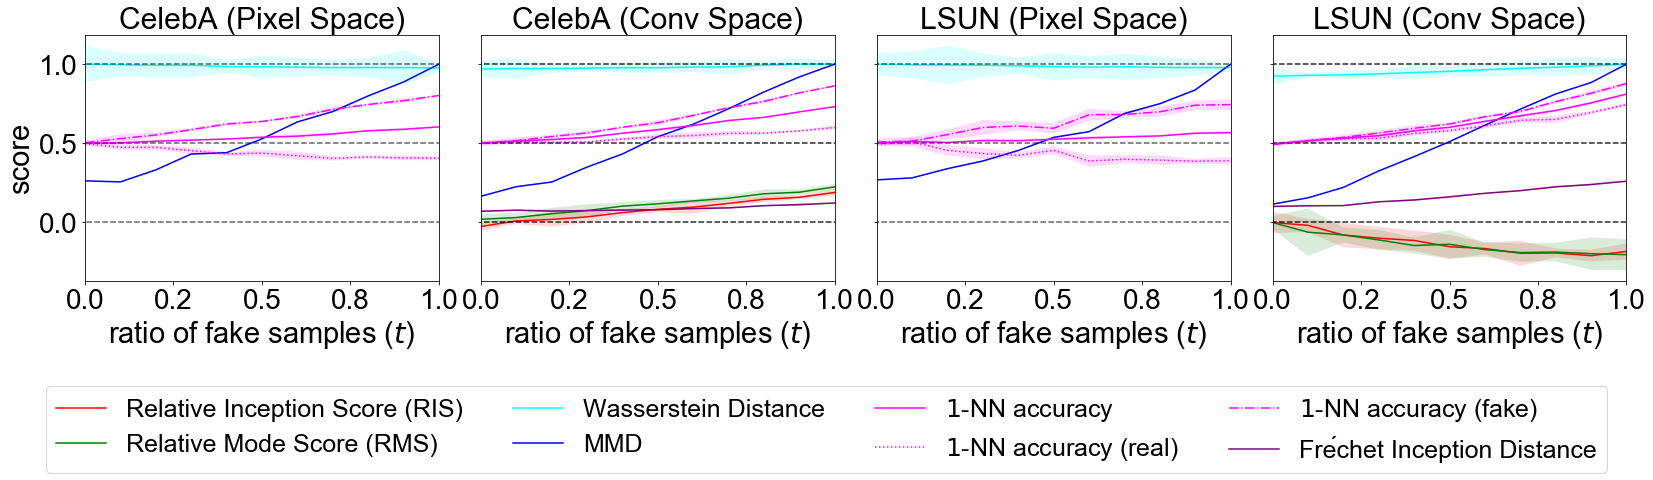

In [51]:
import numpy as np
import matplotlib 
#matplotlib.rcParams.update({'font.size': 17})
matplotlib.rcParams.update({'font.family': 'arial'})
#metricList=['mmd','knn_recall','knn_precision','incep']  #metrics that we care
count=0
fig=None
lastax=None
subfolder = 'resnet/'
for mix1_dat, gan_alg in [('','DCGAN')]:
    for True_data in ['celeba', 'lsun']:    #'celeba'    
        for feature_type in ['pix', 'resnet34_conv']:
            if gan_alg.startswith("DCGAN"):
                mix1_dat=True_data            
                gan_alg='DCGAN24' if True_data=='celeba' else 'DCGAN9'
            
            if feature_type == 'pix':
                metricList=['emd','mmd','knn_acc','knn_acc_t','knn_acc_f']
            else:
                metricList=['incep', 'mode_score', 'emd','mmd','knn_acc','knn_acc_t','knn_acc_f', 'fid']
            fL=[]
            for mix_ratio in np.arange(0,1.1,0.1):
                for dup in [1]:
                    for mode in [0]:
                        for mix2_dat in [True_data]:
                            for mixSize in [2000]:
                                fname= True_data + "_" + feature_type
                                annot=['', '']
                                if 'resnet34' in feature_type:
                                    annot+=['']
                                if mix_ratio<1:
                                    fname+="_"+mix2_dat+"_true_test_"       +"%.2f"%(1-mix_ratio)+"_"+str(dup)+"_"+str(mode)
                                    annot+=['', '','', 'x2', '', '']
                                if mix_ratio>0:
                                    fname+="_"+mix1_dat+"_"+gan_alg+"_"+"%.2f"%(mix_ratio)+"_" +str(dup)+"_"+str(mode)
                                    annot+=['', '', 'x1', '', '']
                                fname+="_"+str(mixSize)
                                annot+=['']                                
                                fL.append((fname,annot))  
            print('drawing')
            fig,lastax=myplot(fL, metricList, title=('CelebA' if True_data=='celeba' else 'LSUN')
                       +" ("+("Conv" if feature_type.endswith("conv") else "Pixel")+" Space)",
                   xlabel="ratio of "+(mix1_dat if gan_alg=='true' else "fake")+" samples ($t$)",
                     normalize=True,count=count,figsize=(22,4),
                              bboxPos=(-3.5,-0.6),
                              #bboxPos=(1.0, 0.5),
                              perrow=4,ncollengend=1,                       
                       f=fig,outName="MixRatioExp"+mix1_dat+""+gan_alg+".eps",legendPos=3, 
                       useCeleba=(True_data=='celeba'),lastax=lastax,myxlim=[-0.0,1.0])
            count+=1   
fig.savefig(g.default_repo_dir+"plots/distinguishability.png", dpi=250, bbox_inches='tight')
fig.savefig(g.default_repo_dir+"plots/distinguishability_pdf.png", dpi=250, bbox_inches='tight', format='pdf')
fig.savefig(g.default_repo_dir+"plots/distinguishability.pdf", dpi=250, bbox_inches='tight', format='pdf') 

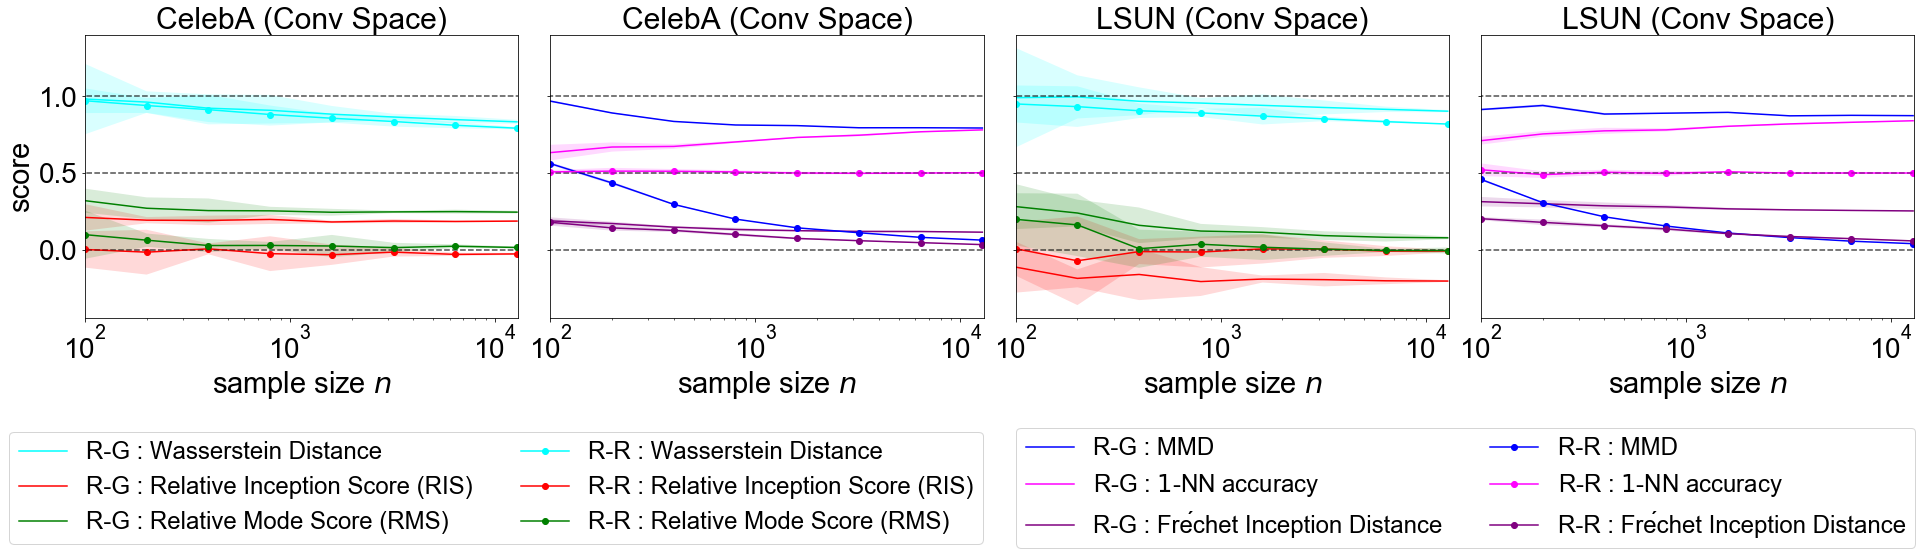

In [34]:
count=0
fig=None
lastax=None

subfolder = 'sample/'

def set_curve_name_1(curves): #should call in
    ans=''
    for key, value in curves.items():
        ans=ans+value
    if ans=='true':
        return 'R-R' #r'$\hat \rho (S_r, S_r\')$' #'Real-Real' #\rho(S_r, S_r\')$
    else:
        return 'R-G'#r'$\hat \rho (S_r, S_r\') $' #'Fake-Real' #\rho(S_r, S_g)
    return ans
for True_data in ['celeba','lsun']:        
    for feature_type in ['resnet34_conv']:
        for metricList in [['emd','incep', 'mode_score'],['mmd','knn_acc', 'fid']]:
            fL=[]    
            for mix1_dat, gan_alg in [('','DCGAN'),('','true_test')]:
                mix1_dat=True_data                            
                if gan_alg.startswith("DCGAN"):
                    gan_alg='DCGAN24' if True_data=='celeba' else 'DCGAN9'

                for mix_ratio in [1]:
                    for dup in [1]:
                        for mode in [0]:
                            for mix2_dat in [True_data]:
                                for mixSize in [100,200, 400, 800, 1600,3200,6400,12800]: #100,200, 400, 
                                #for mixSize in [2000]:
                                    fname= True_data + "_" + feature_type
                                    annot=['', '']
                                    if 'resnet34' in feature_type:
                                        annot+=['']
                                    fname+="_"+mix1_dat+"_"+gan_alg+"_"+"%.2f"%(mix_ratio)+"_" +str(dup)+"_"+str(mode)
                                    annot+=['', 'v1', '', '', '']
                                    if gan_alg=='true_test':
                                        annot+=['']
                                    fname+="_"+str(mixSize)
                                    annot+=['x1']                                
                                    fL.append((fname,annot))        

            fig,lastax=myplot(fL, metricList, title=
                       ('CelebA' if True_data=='celeba' else 'LSUN')
                       +" ("+("Conv" if feature_type.endswith("conv") else "Pixel")+" Space)",
                   xlabel="sample size $n$",
                     normalize=True,count=count,figsize=(26,4.5),
                              bboxPos=(-2.35,-0.6),
                              #bboxPos=(2.05,0.72),
                   f=fig,perrow=4,legendPos=2,ncollengend=1, outName="SampleSizeExp"+gan_alg+".eps",
                              loglogx=True,useCeleba=(True_data=='celeba'),lastax=lastax,myxlim=[-1000,13000],
                              passKey=True,curve_name=set_curve_name_1, doubleLegend=True, 
                              bboxPosDouble=(-1.1,-0.6),
                              #bboxPosDouble=(1.05,0.08),
                             specialScale=True
                            )
            count+=1
fig.savefig(g.default_repo_dir+"plots/samples.png", dpi=250, bbox_inches='tight')
fig.savefig(g.default_repo_dir+"plots/samples.pdf", dpi=250, bbox_inches='tight', format='pdf')

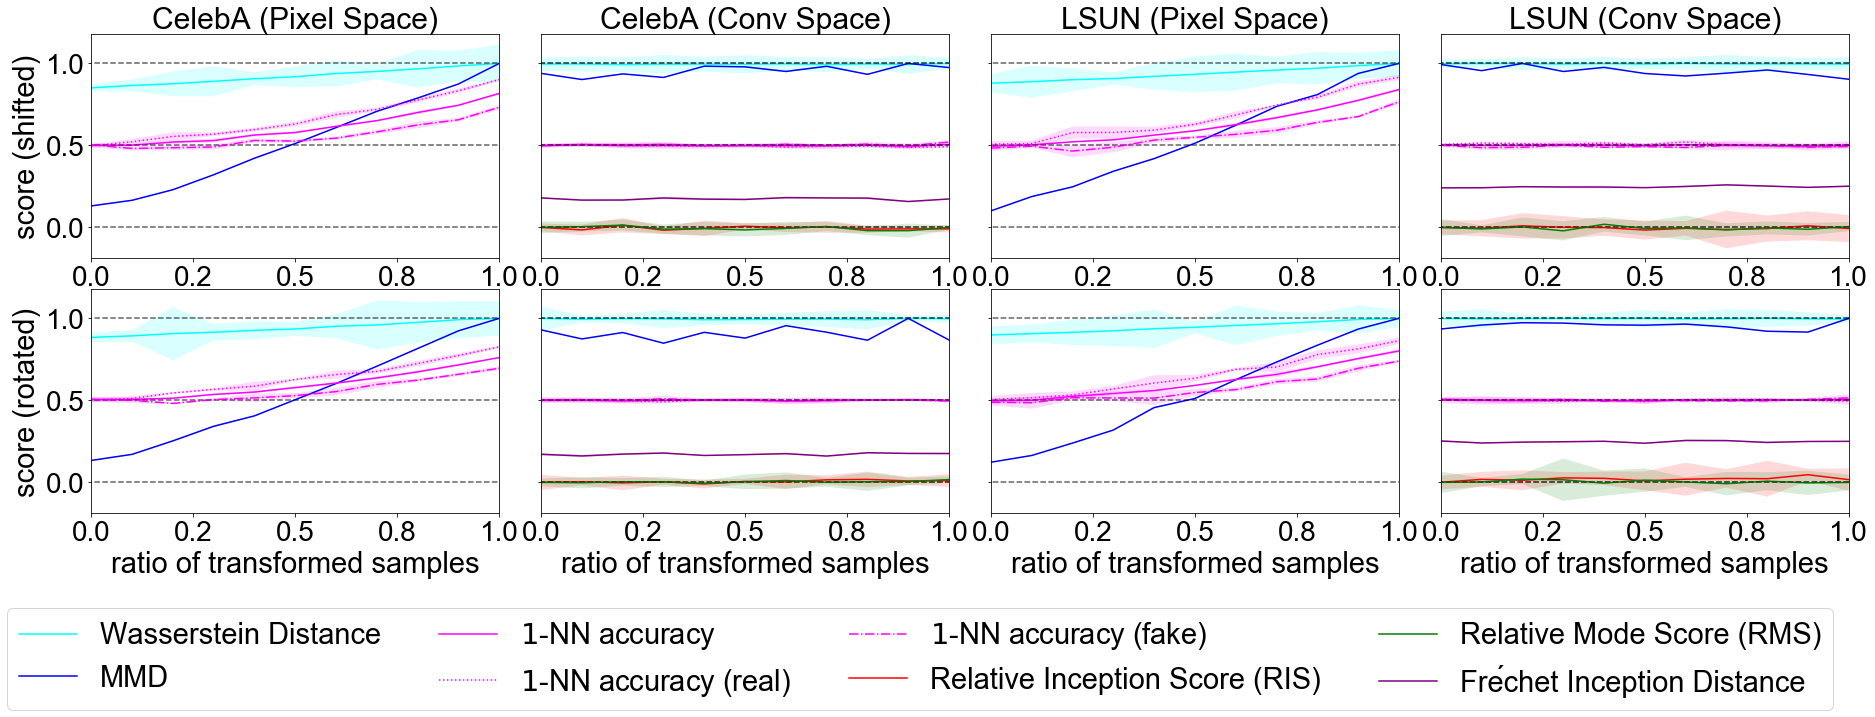

In [48]:
def myplot3(fileNameList, metricList, title='title', xlabel='x', x_value=set_x_value, 
           curve_name=set_curve_name,outf=g.default_repo_dir+"plots/", outName="plot.pdf", 
           normalize=False,count=0,perrow=2,figsize=(6,3),bboxPos=(0.5, 1.05), ncollengend=4,
           f=None,loglogx=False, legendPos=0,useCeleba=True,lastax=None, myxlim=[-0.1,1.1],
           passKey=False,doubleLegend=False,bboxPosDouble=(0.5,1.05),specialScale=False
          ):
    mkdir(outf)
    curves={}
    if count==0:
        f=plt.figure(figsize=figsize)        
        curax=plt.subplot(2,perrow,1)        
        plt.tight_layout(w_pad = 3.5, h_pad = 1.5)
    else:
        curax=plt.subplot(2,perrow,count+1,sharey=lastax)  
    curax.tick_params(labelsize=28)
    curax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if loglogx:
        curax.set_xscale("log", nonposy='clip')
    #f=plt.figure()
    for [fileName,annot] in fileNameList:
        
        cur_y=get_y(fileName,metricList)
        comp=fileName.split("_")   #split the name
        curvList={}
        varList={}
        for c,an in zip(comp,annot):  #for every comp, need to annot
            if an.startswith('vx'):               # it's a curve label!
                curvList[an]=c[:c.index("GAN")+3]
                an=an[1:]
            if an.startswith('v'):               # it's a curve label!
                curvList[an]=c           
            if an.startswith('x'):  # it's a variable!
                varList[an]=c
        curvName=curve_name(curvList)
        xName=x_value(varList)
        if not (curvName in curves):   #if not in curves
            curves[curvName]=[]
        curves[curvName].append((xName,cur_y))  
    
    for key, value in sorted(curves.items()):
        curList=sorted(value,key=lambda x:x[0])
        x=[]
        for (a,_) in curList:
            x.append(a)
        for entry in metricList:
            #print(entry)
            y=[]
            yerr=[]
            for (_,b) in curList:
                y.append(b[entry])
                yerr.append(b[entry+"_std"])
            y=np.array(y)
            #print(x, y)
            yerr=np.array(yerr)
            maximum=1
            if normalize and entry in ['emd','mmd','incep', 'mode_score', 'fid']:
                if entry=='incep':
                    y = 1 - y / y[0]
                elif entry=='mode_score':
                    y = 1 - y / y[0]
                elif entry=='fid':
                    y /= 0.4
                else:
                    if specialScale:
                        if count<2: 
                            if entry=='mmd':
                                maximum=0.14732082
                            elif entry=='emd':
                                maximum=11.0471
                            else:
                                assert(False)
                        else:
                            if entry=='mmd':
                                maximum=0.20002224
                            elif entry=='emd':
                                maximum=17.3404
                            else:
                                assert(False)
                    else:
                        maximum=max(y) if max(y) > 0 else 1   
            #x = [0.1*i for i in range(11)]
            plt.plot(x,y/maximum,label=key+(" : " if key!='' else '')+trans_key(entry),
                         color=get_color(entry),marker=get_maker(key if passKey else None),
                         linestyle=get_linestyle(entry,None))
            plt.plot([-100,14000],[0.5,0.5],color='k',linestyle='dashed',alpha=0.15)
            plt.plot([-100,14000],[0.0,0.0],color='k',linestyle='dashed',alpha=0.15)
            plt.plot([-100,14000],[1,1],color='k',linestyle='dashed',alpha=0.15)
            curax.set_xlim(myxlim)
            
            #if count % 4 == 3:
            #    yerr /= 22
            curax.fill_between(x, y/maximum-yerr, y/maximum+yerr,facecolor=get_color(entry), alpha=0.15)

    label_font_size = 29
    if count < perrow:
        plt.title(title, {'fontsize':30, 'fontname': 'arial'})
    else:
        plt.xlabel(xlabel, fontsize=label_font_size)
        
    if count%perrow>0:
        plt.setp(curax.get_yticklabels(), visible=False)
    else:
        plt.ylabel('score ' + ('(shifted)' if count < perrow else '(rotated)'), fontsize=label_font_size)
        
    if count > 4 and count%perrow==legendPos: 
        plt.legend(loc=6,bbox_to_anchor=bboxPos, ncol=4 if not doubleLegend else 2, fontsize=label_font_size) 
    if count==perrow*2-1:
        plt.show()
        
    
    return f,curax

### Rotation

import numpy as np
import matplotlib 
#matplotlib.rcParams.update({'font.size': 14})
#metricList=['mmd','knn_recall','knn_precision','incep']  #metrics that we care
count=0
fig=None
lastax=None
#subfolder = 'rotation/'
for subfolder in ['shift/', 'rotation/']:
    if subfolder == 'rotation/':
        mode_list = [2]
    else:
        mode_list = [1]
    for mix1_dat, gan_alg in [('','true_test')]:
        for True_data in ['celeba','lsun']:        
            for feature_type in ['pix','resnet34_conv']:
                mix1_dat=True_data
                metricList=['emd','mmd','knn_acc','knn_acc_t','knn_acc_f']
                if feature_type!='pix':
                    metricList.append('incep')
                    metricList.append('mode_score')
                    metricList.append('fid')
                fL=[]    
                for mix_ratio in np.arange(0,1.1,0.1):
                    for dup in [1]:
                        for mode in mode_list:
                            for mix2_dat in [True_data]:
                                for mixSize in [2000]:
                                    fname= True_data + "_" + feature_type
                                    annot=['', '']
                                    if 'resnet34' in feature_type:
                                        annot+=['']
                                    if mix_ratio>0:
                                        fname+="_"+mix1_dat+"_"+gan_alg+"_"+"%.2f"%(mix_ratio)+"_" +str(dup)+"_"+str(mode)
                                        annot+=['', '','', 'x1', '', '']
                                    if mix_ratio<1:
                                        fname+="_"+mix2_dat+"_true_test2_"       +"%.2f"%(1-mix_ratio)+"_"+str(dup)+"_0"
                                        annot+=['', '','', 'x2', '', '']
                                    fname+="_"+str(mixSize)
                                    annot+=['']                                
                                    fL.append((fname,annot))        

                fig,lastax=myplot3(fL, metricList, title=('CelebA' if True_data=='celeba' else 'LSUN')
                           +" ("+("Conv" if feature_type.endswith("conv") else "Pixel")+" Space)",
                       xlabel="ratio of transformed samples",
                         normalize=True,count=count,figsize=(25,7),
                                   bboxPos=(-3.55,-0.65),
                                   #bboxPos=(1.0,1.0),
                                   perrow=4,ncollengend=1,                       
                           f=fig,outName="ShiftMixRatioExp"+mix1_dat+""+gan_alg+".eps",legendPos=3
                          ,useCeleba=(True_data=='celeba'),lastax=lastax,
                                 myxlim=[-0.0,1.0])
                count+=1  
fig.savefig(g.default_repo_dir+"plots/rotation_shift.png", dpi=250, bbox_inches='tight')
fig.savefig(g.default_repo_dir+"plots/rotation_shift_pdf.png", dpi=250, bbox_inches='tight', format='pdf')
fig.savefig(g.default_repo_dir+"plots/rotation_shift.pdf", dpi=250, bbox_inches='tight', format='pdf')

drawing
drawing
drawing
drawing
drawing
drawing
drawing
drawing


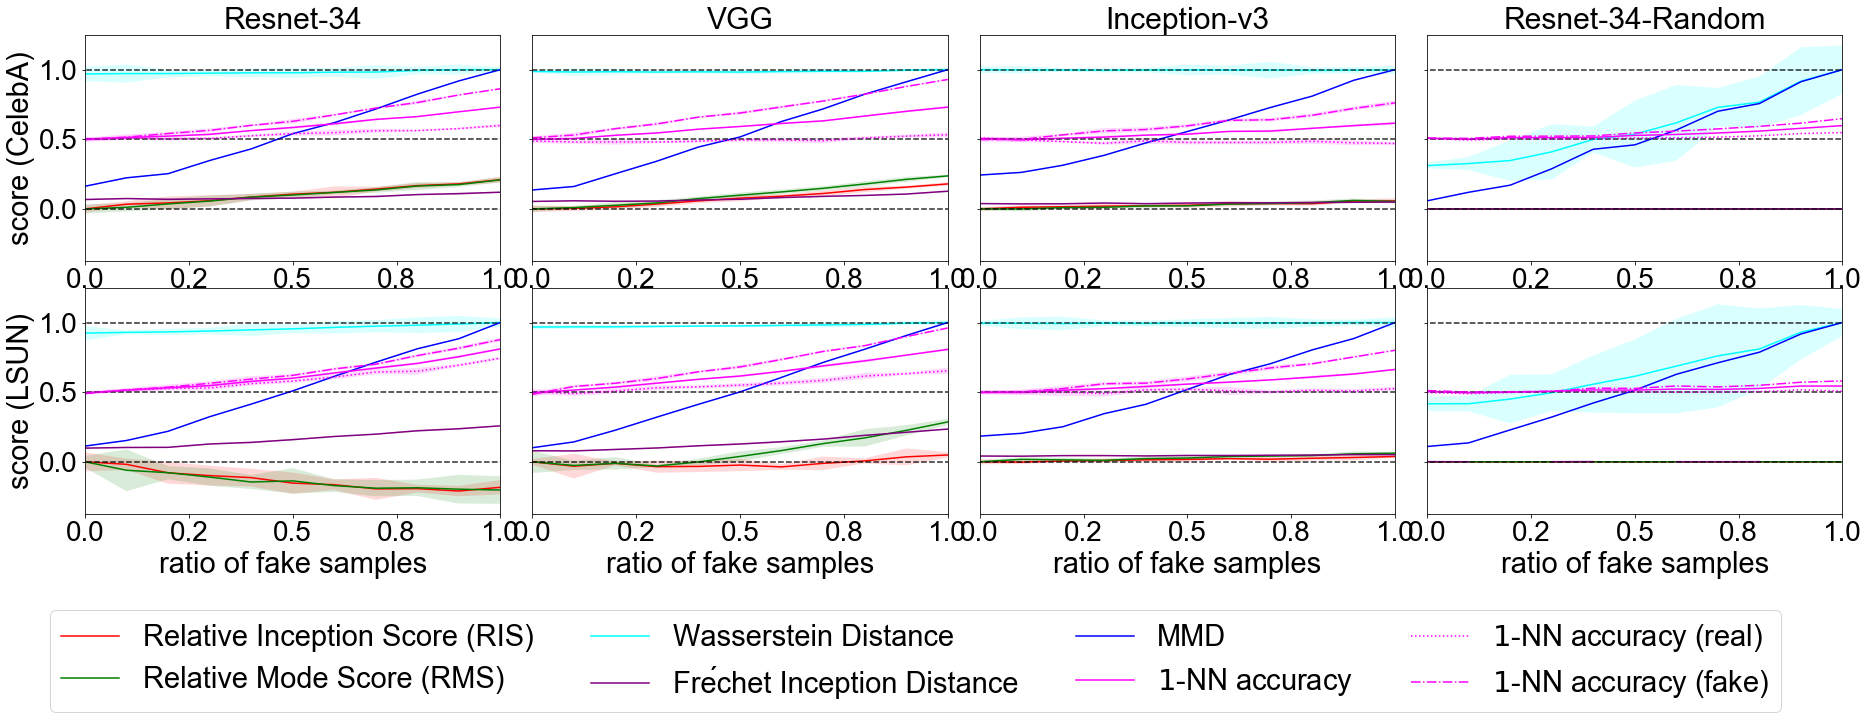

In [54]:
def myplot1(fileNameList, metricList, title='title', xlabel='x', x_value=set_x_value, 
           curve_name=set_curve_name,outf=g.default_repo_dir+"plots/", outName="plot.pdf", 
           normalize=False,count=0,perrow=2,figsize=(6,3),bboxPos=(0.5, 1.05), ncollengend=4,
           f=None,loglogx=False, legendPos=0,useCeleba=True,lastax=None, myxlim=[-0.1,1.1],
           passKey=False,doubleLegend=False,bboxPosDouble=(0.5,1.05),specialScale=False
          ):
    mkdir(outf)
    curves={}
    if count==0:
        f=plt.figure(figsize=figsize)        
        curax=plt.subplot(2,perrow,1)        
        plt.tight_layout(w_pad = 2.5)
    else:
        curax=plt.subplot(2,perrow,count+1,sharey=lastax)  
    curax.tick_params(labelsize=28)
    curax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if loglogx:
        curax.set_xscale("log", nonposy='clip')
    #f=plt.figure()
    for [fileName,annot] in fileNameList:
        
        cur_y=get_y(fileName,metricList)
        comp=fileName.split("_")   #split the name
        curvList={}
        varList={}
        for c,an in zip(comp,annot):  #for every comp, need to annot
            if an.startswith('vx'):               # it's a curve label!
                curvList[an]=c[:c.index("GAN")+3]
                an=an[1:]
            if an.startswith('v'):               # it's a curve label!
                curvList[an]=c           
            if an.startswith('x'):  # it's a variable!
                varList[an]=c
        curvName=curve_name(curvList)
        xName=x_value(varList)
        if not (curvName in curves):   #if not in curves
            curves[curvName]=[]
        curves[curvName].append((xName,cur_y))  
    
    for key, value in sorted(curves.items()):
        curList=sorted(value,key=lambda x:x[0])
        x=[]
        for (a,_) in curList:
            x.append(a)
        for entry in metricList:
            #print(entry)
            y=[]
            yerr=[]
            for (_,b) in curList:
                y.append(b[entry])
                yerr.append(b[entry+"_std"])
            y=np.array(y)
            #print(x, y)
            yerr=np.array(yerr)
            maximum=1
            if normalize and entry in ['emd','mmd','incep', 'mode_score']:
                if entry=='incep':
                    y = 1 - y / y[0]
                elif entry=='mode_score':
                    y = 1 - y / y[0]
                else:
                    if specialScale:
                        if count<2: 
                            if entry=='mmd':
                                maximum=0.14732082
                            elif entry=='emd':
                                maximum=11.0471
                            else:
                                assert(False)
                        else:
                            if entry=='mmd':
                                maximum=0.20002224
                            elif entry=='emd':
                                maximum=17.3404
                            else:
                                assert(False)
                    else:
                        maximum=max(y) if max(y) > 0 else 1   
            #x = [0.1*i for i in range(11)]
            plt.plot(x,y/maximum,label=key+(" : " if key!='' else '')+trans_key(entry),
                         color=get_color(entry),marker=get_maker(key if passKey else None),
                         linestyle=get_linestyle(entry,None))
            plt.plot([-100,14000],[0.5,0.5],color='k',linestyle='dashed',alpha=0.15)
            plt.plot([-100,14000],[0.0,0.0],color='k',linestyle='dashed',alpha=0.15)
            plt.plot([-100,14000],[1,1],color='k',linestyle='dashed',alpha=0.15)
            curax.set_xlim(myxlim)
            
            if count % 4 == 3:
                yerr /= 22
            curax.fill_between(x, y/maximum-yerr, y/maximum+yerr,facecolor=get_color(entry), alpha=0.15)

    label_font_size = 29 
    if count < perrow:
        plt.title(title, {'fontsize':30, 'fontname': 'arial'})
    else:
        plt.xlabel(xlabel, fontsize=label_font_size)
        
    if count%perrow>0:
        plt.setp(curax.get_yticklabels(), visible=False)
    else:
        plt.ylabel('score ' + ('(CelebA)' if count < perrow else '(LSUN)'), fontsize=label_font_size)
        
    if count > 4 and count%perrow==legendPos: 
        plt.legend(loc=6,bbox_to_anchor=bboxPos, ncol=4 if not doubleLegend else 2, fontsize=label_font_size) 
    if count==perrow*2-1:
        plt.show()
        
    
    return f,curax

## Different networks, different training data

import numpy as np
import matplotlib 
#matplotlib.rcParams.update({'font.size': 14})
#metricList=['mmd','knn_recall','knn_precision','incep']  #metrics that we care
count=0
fig=None
lastax=None
ff = plt.figure()
for mix1_dat, gan_alg in [('','DCGAN')]:
    for True_data in ['celeba', 'lsun']:    #'celeba'    
        for feature_type in ['resnet34_conv', 'vgg_conv', 'inception_v3_conv', 'resnet34_random_conv']:
            if gan_alg.startswith("DCGAN"):
                mix1_dat=True_data            
                gan_alg='DCGAN24' if True_data=='celeba' else 'DCGAN9'
            
            if feature_type == 'resnet34_conv': 
                subfolder = 'resnet/'
                ledeng_name = 'Resnet-34'
            elif feature_type == 'vgg_conv': 
                subfolder = 'vgg/'
                ledeng_name = 'VGG'
            elif feature_type == 'resnet34_random_conv': 
                subfolder = 'random/'
                ledeng_name = 'Resnet-34-Random'
            else: 
                subfolder ='inception/'
                ledeng_name = 'Inception-v3'
                
            if feature_type == 'pix':
                metricList=['emd','mmd','knn_acc','knn_acc_t','knn_acc_f']
            else:
                metricList=['incep', 'mode_score', 'emd', 'fid', 'mmd','knn_acc','knn_acc_t','knn_acc_f']
            fL=[]
            for mix_ratio in np.arange(0,1.1,0.1):
                for dup in [1]:
                    for mode in [0]:
                        for mix2_dat in [True_data]:
                            for mixSize in [2000]:
                                fname= True_data + "_" + feature_type
                                annot=['', '']
                                if 'inception_v3' in feature_type or 'resnet34_random' in feature_type:
                                    annot+=['', '']
                                else:
                                    annot+=['']
                                if mix_ratio<1:
                                    fname+="_"+mix2_dat+"_true_test_"       +"%.2f"%(1-mix_ratio)+"_"+str(dup)+"_"+str(mode)
                                    annot+=['', '','', 'x2', '', '']
                                if mix_ratio>0:
                                    fname+="_"+mix1_dat+"_"+gan_alg+"_"+"%.2f"%(mix_ratio)+"_" +str(dup)+"_"+str(mode)
                                    annot+=['', '', 'x1', '', '']
                                fname+="_"+str(mixSize)
                                annot+=['']                                
                                fL.append((fname,annot))  
            print('drawing')
            #if count == 0: fig = ff.add_subplot(211)
            #if count == 4: fig = ff.add_subplot(221)
            fig,lastax=myplot1(fL, metricList, #title=('CelebA' if True_data=='celeba' else 'LSUN')+" (" + ledeng_name+ ")",
                       title = ledeng_name,
                   xlabel="ratio of "+(mix1_dat if gan_alg=='true' else "fake")+" samples",
                     normalize=True,count=count,figsize=(25,7),
                               bboxPos=(-3.35,-0.65),
                               #bboxPos=(1.0,1.0),
                               perrow=4,ncollengend=1,                       
                       f=fig,outName="MixRatioExp"+mix1_dat+""+gan_alg+".eps",legendPos=3, 
                       useCeleba=(True_data=='celeba'),lastax=lastax,myxlim=[-0.00,1.00])
            count+=1
            #if count == 4:
            #    fig.savefig(g.default_repo_dir+"plots/different_features_celeba.png", dpi=250, bbox_inches='tight')
#fig.savefig(g.default_repo_dir+"plots/different_features_lsun.png", dpi=250, bbox_inches='tight')
fig.savefig(g.default_repo_dir+"plots/different_features.png", dpi=250, bbox_inches='tight')
fig.savefig(g.default_repo_dir+"plots/different_features_pdf.png", dpi=250, bbox_inches='tight', format = 'pdf')
fig.savefig(g.default_repo_dir+"plots/different_features.pdf", dpi=250, bbox_inches='tight', format = 'pdf')

drawing
drawing


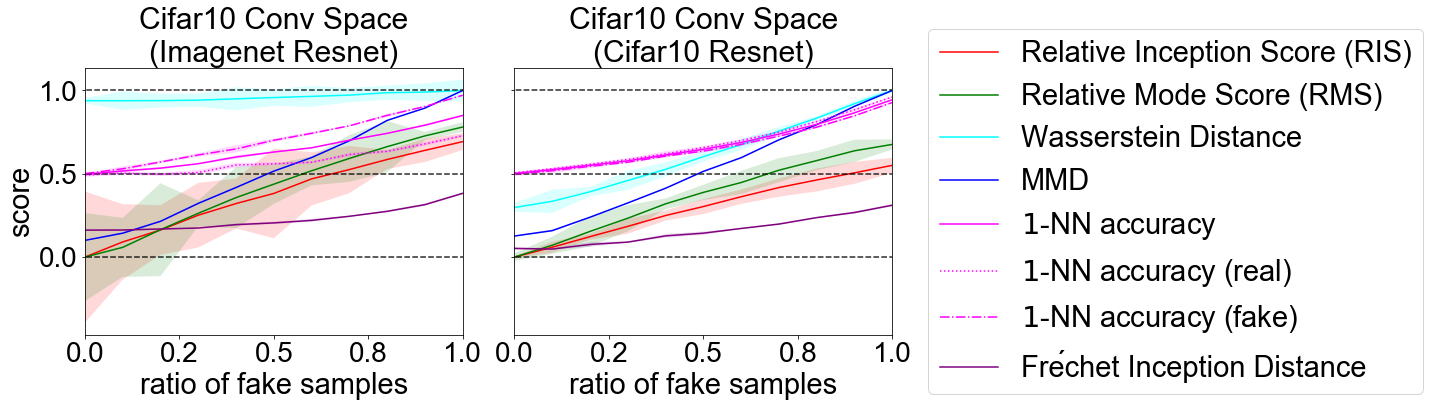

In [86]:

from matplotlib.ticker import FormatStrFormatter

def myplot2(fileNameList, metricList, title='title', xlabel='x', x_value=set_x_value, 
           curve_name=set_curve_name,outf=g.default_repo_dir+"plots/", outName="plot.pdf", 
           normalize=False,count=0,perrow=2,figsize=(6,3),bboxPos=(0.5, 1.05), ncollengend=4,
           f=None,loglogx=False, legendPos=0,useCeleba=True,lastax=None, myxlim=[-0.1,1.1],
           passKey=False,doubleLegend=False,bboxPosDouble=(0.5,1.05),specialScale=False
          ):
    mkdir(outf)
    curves={}
    if count%perrow==0:
        f=plt.figure(figsize=figsize)        
        curax=plt.subplot(1,perrow,1)        
        plt.tight_layout(w_pad = 3)
    else:
        curax=plt.subplot(1,perrow,count%perrow+1,sharey=lastax)     
    curax.tick_params(labelsize=28)
    curax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if loglogx:
        curax.set_xscale("log", nonposy='clip')
    #f=plt.figure()
    for [fileName,annot] in fileNameList:
        
        cur_y=get_y(fileName,metricList)
        comp=fileName.split("_")   #split the name
        curvList={}
        varList={}
        for c,an in zip(comp,annot):  #for every comp, need to annot
            if an.startswith('vx'):               # it's a curve label!
                curvList[an]=c[:c.index("GAN")+3]
                an=an[1:]
            if an.startswith('v'):               # it's a curve label!
                curvList[an]=c           
            if an.startswith('x'):  # it's a variable!
                varList[an]=c
        curvName=curve_name(curvList)
        #print(varList)
        xName=x_value(varList)
        if not (curvName in curves):   #if not in curves
            curves[curvName]=[]
        curves[curvName].append((xName,cur_y))  
    #print(len(curves))
    
    for key, value in sorted(curves.items()):
        curList=sorted(value,key=lambda x:x[0])
        x=[]
        for (a,_) in curList:
            x.append(a)
        for entry in metricList:
            #print(entry)
            y=[]
            yerr=[]
            for (_,b) in curList:
                y.append(b[entry])
                yerr.append(b[entry+"_std"])
            y=np.array(y)
            #print(x, y)
            yerr=np.array(yerr)
            maximum=1
            if normalize and entry in ['emd','mmd','incep', 'mode_score']:
                if entry=='incep':
                    y = 1 - y / y[0]
                    #if useCeleba:
                    #    y=1.0-y/2.3997    #2.3997 for pretrained resnet34
                                                 #1.0236987485292279 for random resnet18
                                                 #1.9437 for incep, 2.1401051412 vgg
                                                 #2.56592524999 cifar10
                                                 # 1.95152185474 for random resnet34
                    #else:
                    #    y=1.0-y/3.2405    # 3.2405 for pretrained resnet34
                                                 # 1.655 incep
                                                 # 3.30022240946 vgg
                                                 # 2.7562591764 cifar10
                                                 # 9.92975601388 for just cifar10, cifar10 resnet
                                                 # 15.9915169408 for just cifar10, resnet
                                                 # 1.00046539489 for random resnet34
                   # print(y)
                elif entry=='mode_score':
                    y = 1 - y / y[0]
                    #if useCeleba:
                    #    y=1.0-y/2.4976243287698954    #2.4976243287698954 for pretrained resnet34
                                                 #1.0235724787091891 for random resnet18
                                                 #1.92903664435 for incep
                                                 #2.19678302136 for vgg
                                                 #2.54771686188 for cifar10
                                                 # 1.00017484414 for random resnet34
                    #else:
                    #    y=1.0-y/3.2376559712668476    #3.2376559712668476 for pretrained resnet34
                                                 #1.66798955183 for incep
                                                 #3.23325699458 for vgg
                                                 #2.74160413123 for cifar10
                                                 # 9.93341207815 for just cifar10, cifar10 resnet
                                                 # 15.6832007115 for just cifar10, resnet
                                                 # 1.00048718068 for random resnet34
                else:
                    if specialScale:
                        if count<2: 
                            if entry=='mmd':
                                maximum=0.14732082
                            elif entry=='emd':
                                maximum=11.0471
                            else:
                                assert(False)
                        else:
                            if entry=='mmd':
                                maximum=0.20002224
                            elif entry=='emd':
                                maximum=17.3404
                            else:
                                assert(False)
                    else:
                        maximum=max(y) if max(y) > 0 else 1   
            #x = [0.1*i for i in range(11)]
            plt.plot(x,y/maximum,label=key+(" : " if key!='' else '')+trans_key(entry),
                         color=get_color(entry),marker=get_maker(key if passKey else None),
                         linestyle=get_linestyle(entry,None))
            plt.plot([-100,14000],[0.5,0.5],color='k',linestyle='dashed',alpha=0.15)
            plt.plot([-100,14000],[0.0,0.0],color='k',linestyle='dashed',alpha=0.15)
            plt.plot([-100,14000],[1,1],color='k',linestyle='dashed',alpha=0.15)
            curax.set_xlim(myxlim)
            
            #if count % 4 == 3:
            #    yerr /= 22
            curax.fill_between(x, y/maximum-yerr, y/maximum+yerr,facecolor=get_color(entry), alpha=0.15)

        #assert(False)

    label_font_size = 29
    plt.xlabel(xlabel, fontsize=label_font_size) #fontsize=18, {'fontsize':30, 'fontname': 'arial'}
    plt.title(title, {'fontsize':30, 'fontname': 'arial'})  
    #print(count%perrow, legendPos, doubleLegend)
    if count%perrow>0:
        plt.setp(curax.get_yticklabels(), visible=False)
    else:
        plt.ylabel('score', fontsize=label_font_size)
    if count%perrow==legendPos: #count > 4 and 
        #print('printing ledgend')
        plt.legend(loc='upper center',bbox_to_anchor=bboxPos, ncol=ncollengend, fontsize=label_font_size)       
        #plt.legend(loc=6,bbox_to_anchor=bboxPos, ncol=4 if not doubleLegend else 2, fontsize=label_font_size) #{'fontsize':18, 'fontname': 'arial'}
    if doubleLegend and count%perrow==3:
        plt.legend(loc=6,bbox_to_anchor=bboxPosDouble, ncol=2, fontsize=label_font_size)
    if count%perrow==perrow-1:
        plt.show()
        
    
    return f,curax

import numpy as np
import matplotlib 
matplotlib.rcParams.update({'font.size': 14})
#metricList=['mmd','knn_recall','knn_precision','incep']  #metrics that we care
count=0
fig=None
lastax=None
for mix1_dat, gan_alg in [('','WGAN1900')]:
    for True_data in ['cifar10']:    #'celeba'    
        for feature_type in ['resnet34_conv', 'resnet34C_conv']:   
            mix1_dat=True_data            
            if feature_type == 'resnet34_conv': subfolder = 'cifar10_imagenet/'
            else: subfolder = 'cifar10_cifar10/'
            
            if feature_type == 'pix':
                metricList=['emd','mmd','knn_acc','knn_acc_t','knn_acc_f']
            else:
                metricList=['incep', 'mode_score', 'emd','mmd','knn_acc','knn_acc_t','knn_acc_f', 'fid']
            fL=[]
            for mix_ratio in np.arange(0,1.1,0.1):
                for dup in [1]:
                    for mode in [0]:
                        for mix2_dat in [True_data]:
                            for mixSize in [2000]:
                                fname= True_data + "_" + feature_type
                                annot=['', '']
                                if 'inception_v3' in feature_type or 'resnet34_random' in feature_type:
                                    annot+=['', '']
                                else:
                                    annot+=['']
                                if mix_ratio<1:
                                    fname+="_"+mix2_dat+"_true_test_"       +"%.2f"%(1-mix_ratio)+"_"+str(dup)+"_"+str(mode)
                                    annot+=['', '','', 'x2', '', '']
                                if mix_ratio>0:
                                    fname+="_"+mix1_dat+"_"+gan_alg+"_"+"%.2f"%(mix_ratio)+"_" +str(dup)+"_"+str(mode)
                                    annot+=['', '', 'x1', '', '']
                                fname+="_"+str(mixSize)
                                annot+=['']                                
                                fL.append((fname,annot))  
            print('drawing')
            fig,lastax=myplot2(fL, metricList, title='Cifar10 Conv Space\n('
                       +("Imagenet" if feature_type == 'resnet34_conv' else 'Cifar10') + ' Resnet)',
                   xlabel="ratio of "+(mix1_dat if gan_alg=='true' else "fake")+" samples",
                     normalize=True,count=count,figsize=(12,4.5),bboxPos=(1.75,1.2),perrow=2,ncollengend=1,                       
                       f=fig,outName="MixRatioExp"+mix1_dat+""+gan_alg+".eps",legendPos=1, 
                       useCeleba=(True_data=='celeba'),lastax=lastax,myxlim=[-0.00,1.00])
            count+=1
fig.savefig(g.default_repo_dir+"plots/cifar10.png", dpi=250, bbox_inches='tight')
fig.savefig(g.default_repo_dir+"plots/cifar10_pdf.png", dpi=250, bbox_inches='tight', format = 'pdf')
fig.savefig(g.default_repo_dir+"plots/cifar10.pdf", dpi=250, bbox_inches='tight', format = 'pdf')

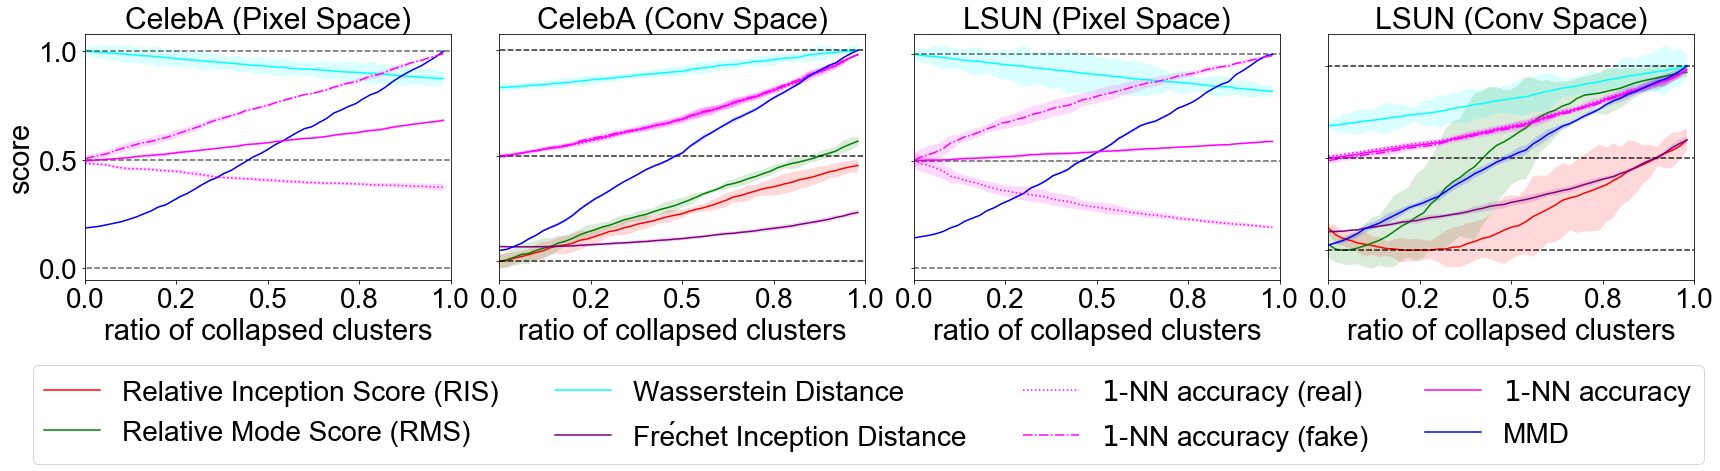

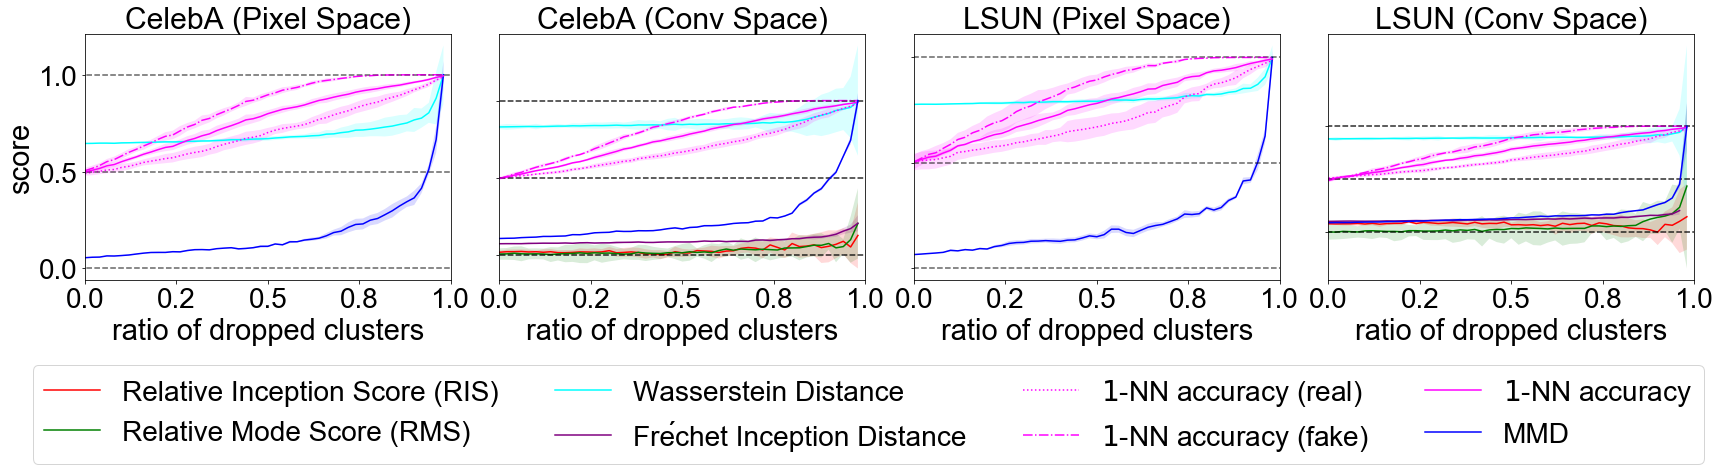

In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call

img_cnt = 0
label_font_size = 29

for score_type in ['collapse', 'drop']:
    f = plt.figure(figsize=[24,5]) 
    for data in ['celeba', 'lsun']: 
        for feature_type in ['pix', 'conv']:
            if feature_type == 'pix':
                metricList = ['emd', 'mmd', 'knn_acc_t', 'knn_acc_f', 'knn_acc']
            else:
                metricList = ['incep', 'mode_score', 'emd', 'fid','knn_acc_t','knn_acc_f', 'knn_acc','mmd'] #knn_acc
            for metric in metricList:
                scoreList = []
                for i in range(5):
                    a = torch.load('../data/repo/rlt/fw_data/{}_{}_scores_{}.pth'.format(data, score_type, i))
                    if metric == 'incep': 
                        scoreList.append(a[2])
                        continue
                    if metric == 'mode_score':
                        scoreList.append(a[3])
                        continue
                    if metric == 'fid':
                        scoreList.append(a[4])
                        continue
                        
                    if feature_type == 'pix': a = a[0]
                    else: a = a[1]
                    
                    if metric == 'emd': 
                        scoreList.append(a[:, 0])
                        continue
                    if metric == 'mmd':
                        scoreList.append(a[:, 1])
                        continue
                    if metric == 'knn_acc_t': 
                        scoreList.append(a[:, 2])
                        continue
                    if metric == 'knn_acc_f':
                        scoreList.append(a[:, 3])
                        continue   
                    if metric == 'knn_acc':
                        scoreList.append((a[:, 3] + a[:, 2])/2)
                        continue
                scoreList = np.array(scoreList)
                y = scoreList.mean(0)

                if metric == 'incep' or metric == 'mode_score':
                    y = 1-y/y.max()
                elif metric == 'emd' or metric == 'mmd':
                    y = y/y.max()
                
                yerr = scoreList.std(0)
                if metric == 'emd' and score_type == 'drop' and feature_type == 'pix':
                    yerr /= 10
                if metric == 'incep' and score_type == 'drop' and feature_type == 'conv':
                    yerr /= 3
                if metric == 'emd':
                    yerr /= 3
                
                x = np.array([float(i) for i in range(50)])/50

                passKey = False
                xlabel = 'ratio of {} clusters'.format(
                    'collapsed' if score_type == 'collapse' else 'dropped')
                title = '{} ({} Space)'.format(
                    'CelebA' if data == 'celeba' else 'LSUN',
                    'Pixel' if feature_type == 'pix' else 'Conv')       
                curax=plt.subplot(1,4,img_cnt%4+1) 
                curax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                plt.tight_layout(w_pad = 1.0)

                plt.plot(x,y,label=trans_key(metric),
                                         color=get_color(metric),marker=get_maker(metric if passKey else None),
                                         linestyle=get_linestyle(metric,None))
                plt.plot([-100,14000],[0.5,0.5],color='k',linestyle='dashed',alpha=0.15)
                plt.plot([-100,14000],[0.0,0.0],color='k',linestyle='dashed',alpha=0.15)
                plt.plot([-100,14000],[1,1],color='k',linestyle='dashed',alpha=0.15)
                curax.set_xlim([-0.,1.0])
                curax.fill_between(x, y-yerr, y+yerr,facecolor=get_color(metric), alpha=0.15)
                curax.tick_params(labelsize=28)
                if img_cnt%4 != 0:
                    plt.setp(curax.get_yticklabels(), visible=False)
                else:
                    plt.ylabel('score', fontsize=label_font_size)
                
                plt.xlabel(xlabel, fontsize=label_font_size)
                plt.title(title, {'fontsize':30, 'fontname': 'arial'}) 
            img_cnt += 1
    plt.legend(loc=6,
               bbox_to_anchor=(-3.58,-0.55), ncol=4,
               #bbox_to_anchor=(1.0,0.5), ncol=1,
               fontsize=28) # bboxPosDouble(0.5,1.05), ncollengend(4
    plt.show()
    f.savefig(g.default_repo_dir+"plots/"+score_type+".png", dpi=250, bbox_inches='tight')
    f.savefig(g.default_repo_dir+"plots/"+score_type+"_pdf.png", dpi=250, bbox_inches='tight', format='pdf')
    f.savefig(g.default_repo_dir+"plots/"+score_type+".pdf", dpi=250, bbox_inches='tight', format='pdf')

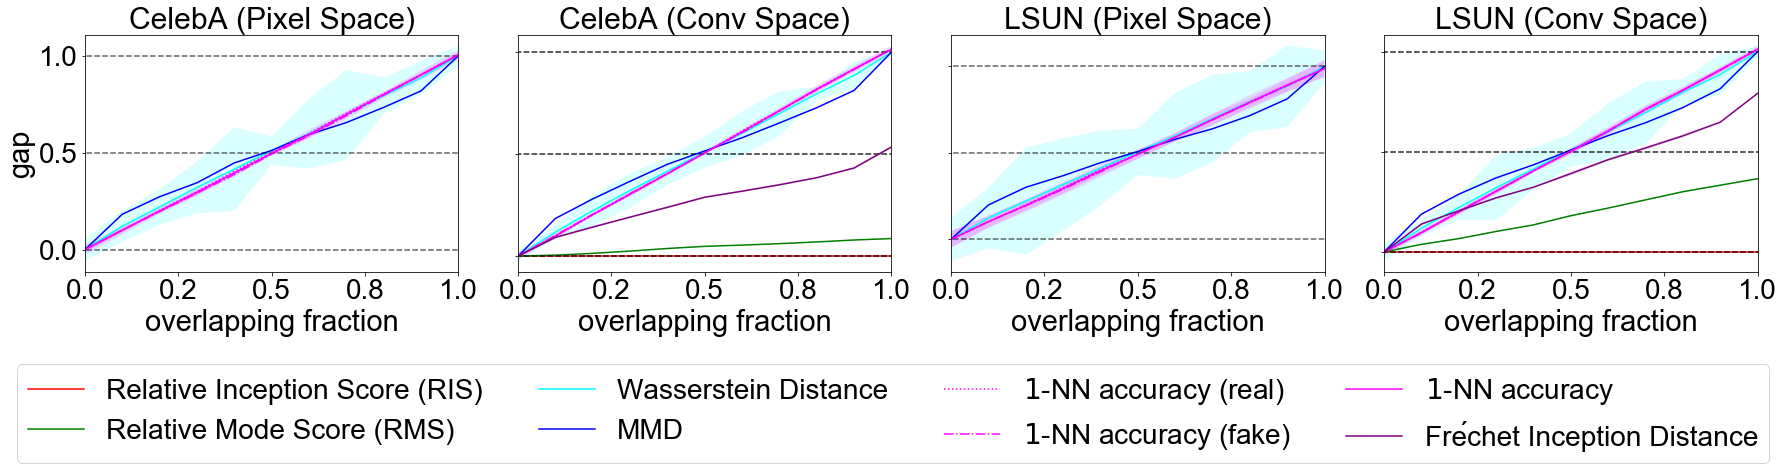

In [85]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call

f = plt.figure(figsize=[25,5])

img_cnt = 0
label_font_size = 29

for data in ['celeba', 'lsun']: #, 'lsun'
    for feature_type in ['pix', 'conv']:
        if feature_type == 'pix':
            metricList = ['emd', 'mmd', 'knn_acc_t', 'knn_acc_f', 'knn_acc']
        else:
            metricList = ['incep', 'mode_score', 'emd','mmd','knn_acc_t','knn_acc_f', 'knn_acc', 'fid']
        
        img_cnt += 1
        curax=plt.subplot(1,4,img_cnt)
        for metric in metricList:
            scoreList = []
            for i in range(5):
                a = torch.load('../data/repo/rlt/fw_data/new_{}_overfit_scores_{}.pth'.format(data, i))
                #print(a)
                if metric == 'incep': 
                    scoreList.append(a[2])
                    #print(metric, a[2])
                    continue
                if metric == 'mode_score':
                    scoreList.append(a[3])
                    #print(metric, a[3])
                    continue
                if metric == 'fid':
                    scoreList.append(a[4])
                    #print(metric, a[4])
                    continue

                if feature_type == 'pix': a = a[0]
                else: a = a[1]

                if metric == 'emd': 
                    scoreList.append(a[:, 0])
                    continue
                if metric == 'mmd':
                    scoreList.append(a[:, 1])
                    continue
                if metric == 'knn_acc_t': 
                    scoreList.append(a[:, 2])
                    continue
                if metric == 'knn_acc_f':
                    scoreList.append(a[:, 3])
                    continue   
                if metric == 'knn_acc':
                    scoreList.append((a[:, 3] + a[:, 2])/2)
                    continue
            scoreList = np.array(scoreList)

            yerr = scoreList.std(0)
            y = scoreList.mean(0)
            #print(metric, y)
            
            
            #if metric == 'fid': 
            #    y[-1] = 0
            #    print(y)
            y -= y[0]
            if metric == 'emd' or metric == 'mmd':# or 'knn' in metric:
                y = y/y.max()
            if metric == 'incep' or metric == 'mode_score':
                y -= y[-1]
                y = y[0] - y
            if metric == 'fid' or metric == 'mode_score':
                y /= 0.25
            
                
            x = np.array([float(i) for i in range(11)])/10

            passKey = False
            xlabel = 'overlapping fraction'
            title = '{} ({} Space)'.format(
                'CelebA' if data == 'celeba' else 'LSUN',
                'Pixel' if feature_type == 'pix' else 'Conv')       
            curax=plt.subplot(1,4,img_cnt) 
            plt.tight_layout(w_pad = 1.5)

            plt.plot(x,y,label=trans_key(metric),
                                     color=get_color(metric),marker=get_maker(metric if passKey else None),
                                     linestyle=get_linestyle(metric,None))
            plt.plot([-100,14000],[0.5,0.5],color='k',linestyle='dashed',alpha=0.15)
            plt.plot([-100,14000],[0.0,0.0],color='k',linestyle='dashed',alpha=0.15)
            plt.plot([-100,14000],[1,1],color='k',linestyle='dashed',alpha=0.15)
            curax.set_xlim([-0.0,1.0])
            curax.fill_between(x, y-yerr, y+yerr,facecolor=get_color(metric), alpha=0.15)
            curax.tick_params(labelsize=28)
            curax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            if (img_cnt-1)%4 != 0:
                plt.setp(curax.get_yticklabels(), visible=False)
            else:
                    plt.ylabel('gap', fontsize=label_font_size)
                
            plt.xlabel(xlabel, fontsize=label_font_size)
            plt.title(title, {'fontsize':30, 'fontname': 'arial'}) 
            
plt.legend(loc=6,
           bbox_to_anchor=(-3.7,-0.6), ncol=4,
           #bbox_to_anchor=(1.0,0.5), ncol=1,
           fontsize=28)
plt.show()
#f.savefig(g.default_repo_dir+"plots/overfitting.png", dpi=250, bbox_inches='tight')
#f.savefig(g.default_repo_dir+"plots/overfitting_pdf.png", dpi=250, bbox_inches='tight', format='pdf')
#f.savefig(g.default_repo_dir+"plots/overfitting.pdf", dpi=250, bbox_inches='tight', format='pdf')